# NASDAQ Stock Indices

#### March 2017
<u>Statistics 141B:</u> Data and Web Technologies<br>
<u>Contributors:</u> Jeremy Weidner, Weizhou Wang, Audrey Chu, and Yuji Mori

### I. Abstract

To study NASDAQ stock prices for the technology, finance, health care, and energy industry sectors across time.  With the application of python and utilization of the Yahoo! Finance API, Yahoo Query Language (YQL), and New York Times API, we will gather and clean out a dataset for a time period of ten years for approximately 1770 companies.  Our data will incorporate the closing prices for each day and then average these prices for each respective sector.  In analyzing the stock prices, we will use interactive data visualization as well as attempt to create a time series ARIMA (Autoregressive Integrated Moving Average) model.

### II. Questions of Interest
- How do stock prices differ among industry sectors?
- Can we explain unusual trends in past prices by relating them to major historical events?
- Which month for which sector has the least volatility?

In [1]:
import sys
import csv
import json
import requests
import requests_cache
import numpy as np
import pandas as pd
#from yahoo_finance import Share
from pprint import pprint 
from datetime import datetime
import matplotlib.pyplot as plt
import math

import matplotlib as mpl
%matplotlib inline

import seaborn as sns
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

import missingno as msno

#this is for time series
from  __future__ import print_function
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

#this is for plotting the prices
import plotly
plotly.tools.set_credentials_file(username="audchu",api_key="fPSZjEJ6wqYjzolZ8wNI")
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime
from pandas_datareader import data,wb

#this is for streaming plot
from plotly.grid_objs import Grid,Column
import time

In [2]:
requests_cache.install_cache('cache')

In [3]:
# Yahoo! YQL API
PUBLIC_API_URL = 'https://query.yahooapis.com/v1/public/yql'
OAUTH_API_URL = 'https://query.yahooapis.com/v1/yql'
DATATABLES_URL = 'store://datatables.org/alltableswithkeys'

def myreq(ticker, start, end):
    '''
    input ticker & dates as strings form 'YYYY-MM-DD'
    '''
    params = {'format':'json',
             'env':DATATABLES_URL}
    query = 'select * from yahoo.finance.historicaldata where symbol = "{}" and startDate = "{}" and endDate = "{}"'.format(ticker,start, end)
    params.update({'q':query})
    req = requests.get(PUBLIC_API_URL, params=params)
    req.raise_for_status()
    req = req.json()
    if req['query']['count'] > 0:
        result = req['query']['results']['quote']
        return result
    else:
        pass

In [4]:
def price2(ticker):
    """
    Return closing prices for stocks from years 2006 to 2016.
    """
    
    date=[]
    price=[]
    report = []
    
    years = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
    for x in range(len(years)):
        c = myreq(ticker,'{}-01-01'.format(years[x]),'{}-12-31'.format(years[x]))
        try:
        
            for i in range(0,len(c)):
                date.append(pd.to_datetime(c[i]["Date"]))
                price.append(float(c[i][u'Close']))
                datef = pd.DataFrame(date)
                pricef = pd.DataFrame(price)
                table1 = pd.concat([datef,pricef],axis = 1)
                table1.columns = ['Date', ticker]
                table1 = table1.set_index("Date")
            
        except Exception:
            table1 = pd.DataFrame()
    
    return table1

In [5]:
csv = pd.read_csv('./companylist.csv')
# We want to keep "Finance, Health Care, Technology, Energy"
newcsv = csv[csv["Sector"].isin(["Finance", "Energy","Health Care","Technology"])].reset_index()
del newcsv["index"]

In [6]:
whole_list = newcsv['Symbol']

In [7]:
'''
for l in whole_list:
    get = price2(l)
    try:
        df = pd.concat([df,get],axis = 1)    # concat. by column 
    except NameError:
        df = pd.DataFrame(get)    # initialize automatically
# SAVE THE RESULT LOCALLY:
df.to_pickle('mydf')
'''

"\nfor l in whole_list:\n    get = price2(l)\n    try:\n        df = pd.concat([df,get],axis = 1)    # concat. by column \n    except NameError:\n        df = pd.DataFrame(get)    # initialize automatically\n# SAVE THE RESULT LOCALLY:\ndf.to_pickle('mydf')\n"

In [8]:
df = pd.read_pickle('mydf')

In [9]:
# This allows us to control size of a dataframe displayed to examine our data in depth
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30

In [10]:
df.head()

,PIH,FCCY,SRCE,VNET,TWOU,JOBS,ABEO,ABIL,ABMD,AXAS,...,ZLTQ,ZN,ZION,ZIONW,ZIOP,ZIXI,ZGNX,ZSAN,ZYNE,ZNGA
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,NaN,21.499973,25.830002,NaN,NaN,14.95,0.51,NaN,9.35,5.55,...,NaN,NaN,76.480003,NaN,3.60,1.93,NaN,NaN,NaN,NaN
2006-01-04,NaN,21.499973,25.659998,NaN,NaN,14.79,0.47,NaN,9.62,5.55,...,NaN,NaN,77.019997,NaN,4.00,2.04,NaN,NaN,NaN,NaN
2006-01-05,NaN,20.999980,25.820004,NaN,NaN,16.15,0.46,NaN,9.55,5.81,...,NaN,NaN,77.720001,NaN,4.00,2.20,NaN,NaN,NaN,NaN
2006-01-06,NaN,20.519969,25.950002,NaN,NaN,17.08,0.45,NaN,9.75,5.95,...,NaN,NaN,78.529999,NaN,4.25,2.09,NaN,NaN,NaN,NaN


In [11]:
final = newcsv.reset_index()
df_long = df.transpose()
sector  = final[['Symbol','Sector']]
sector = sector.set_index('Symbol')

In [12]:
final = df_long.join(sector)

In [13]:
final.head()

,2006-01-02 00:00:00,2006-01-03 00:00:00,2006-01-04 00:00:00,2006-01-05 00:00:00,2006-01-06 00:00:00,2006-01-09 00:00:00,2006-01-10 00:00:00,2006-01-11 00:00:00,2006-01-12 00:00:00,2006-01-13 00:00:00,...,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-26 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00,Sector
PIH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.601000,7.583000,7.400000,7.650000,NaN,7.400000,7.400000,7.250000,7.800000,Finance
FCCY,NaN,21.499973,21.499973,20.999980,20.519969,20.249976,19.999980,20.369968,20.000001,20.779999,...,17.549999,17.350000,17.280001,17.350000,NaN,18.100000,18.250000,18.000000,18.700001,Finance
SRCE,NaN,25.830002,25.659998,25.820004,25.950002,25.999997,25.999997,25.999997,25.940002,25.989997,...,45.000000,44.439999,44.400002,44.200001,NaN,44.740002,44.700001,45.330002,44.660000,Finance
VNET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.320000,7.100000,6.990000,7.050000,NaN,7.150000,7.090000,6.960000,7.010000,Technology
TWOU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.049999,32.099998,30.740000,30.809999,NaN,30.549999,30.340000,29.770000,30.150000,Technology


In [14]:
hc = final[final['Sector'] == 'Health Care']

In [15]:
# take median within groups for each recorded date:
avg_sector = final.groupby('Sector').median().reset_index('Sector')
avg_sector = avg_sector.set_index('Sector')
avg_sector = avg_sector.dropna(thresh=4, axis = 1) # this drops if a column does not have at least two non NA's

In [16]:
# Dates as index for plotting
# This is basically the original DF (transposed and transposed back)
# but the columns are now the Sector averages.
avg_T = avg_sector.transpose()

In [17]:
avg_T.head()

Sector,Energy,Finance,Health Care,Technology
2006-01-03 00:00:00,13.565,23.250000,6.945685,11.245
2006-01-04 00:00:00,13.460,23.309999,6.925000,11.655
2006-01-05 00:00:00,13.750,23.459999,6.990000,11.770
2006-01-06 00:00:00,13.700,23.400000,7.019992,11.775
2006-01-09 00:00:00,13.790,23.500000,7.100000,12.050


In [18]:
def ts_slider(sector,sec_name):
    trace = go.Scatter(x=avg_T.index,y=sector)
    data = [trace]
    layout = dict(
        title=sec_name + ' Sector Closing Prices: Time series with Range Slider',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(count=1,
                        label='YTD',
                        step='year',
                        stepmode='todate'),
                    dict(count=1,
                        label='1y',
                        step='year',
                        stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(),
            type='date'
        )
    )

    fig = dict(data=data, layout=layout)
    return py.iplot(fig)

In [19]:
ts_slider(avg_T.Energy,"Energy")

## Volatility Analysis

In [20]:
# A new DF for the difference between each day:
delta_df = pd.DataFrame()
for sect in avg_T.columns:
    delta_df[sect] = np.log(avg_T[sect].shift(1)) - np.log(avg_T[sect])
delta_df.columns = map(lambda name: '{} Changes'.format(name),avg_T.columns)

# On what day did the stock price spike the most?
abs(delta_df).idxmax()

Energy Changes        2008-10-06
Finance Changes       2008-12-01
Health Care Changes   2008-11-19
Technology Changes    2008-12-01
dtype: datetime64[ns]

In [21]:
shade = delta_df['Energy Changes']

In [22]:
delta_df.head()

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,0.007771,-0.002577,0.002982,-0.035812
2006-01-05,-0.021316,-0.006414,-0.009343,-0.009819
2006-01-06,0.003643,0.002561,-0.004282,-0.000425
2006-01-09,-0.006548,-0.004264,-0.011333,-0.023086


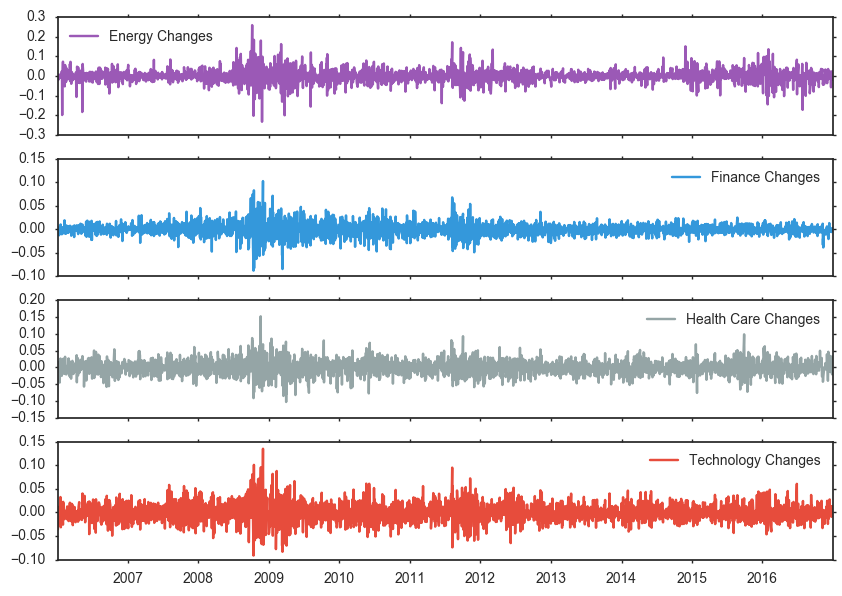

In [23]:
plot_cols = list(delta_df)

# 2 axes for 2 subplots
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
#delta_df[plot_cols].plot(subplots=True, ax=axes)
delta_df[plot_cols].plot(subplots=True, ax=axes)
#plt.ylim([-0.20,0.150])
plt.show()

### Changes of Average Stock Price by Month

In [24]:
avg_T.index= pd.to_datetime(avg_T.index)
avg_month = avg_T.groupby([avg_T.index.year, avg_T.index.month]).mean()
avg_month.head()

Sector     Energy    Finance  Health Care  Technology
2006 1  14.183000  23.605500     7.159611   11.686500
     2  15.404737  23.857619     7.334495   11.895263
     3  14.699130  23.953911     7.656957   12.523913
     4  15.968421  23.920786     7.665814   13.029474
     5  17.850000  23.418863     7.096370   12.887273

In [25]:
plot_cols

['Energy Changes',
 'Finance Changes',
 'Health Care Changes',
 'Technology Changes']

In [26]:
# A new DF for the difference between each month's average:
delta_avg = pd.DataFrame()

for sect in avg_month.columns:
    delta_avg[sect] = np.log(avg_month[sect].shift(1)) - np.log(avg_month[sect])
delta_avg.columns = map(lambda name: '{} Changes'.format(name),avg_month.columns)

col = []
for i in range(len(delta_avg)):
    dt = delta_avg.index[i] + (10, 10, 10, 10)
    dt_obj = datetime(*dt[0:6])
    col.append(pd.to_datetime(dt_obj))

In [27]:
delta_avg['Timestamp'] = col

In [28]:
delta_avg = delta_avg.set_index('Timestamp')

In [29]:
delta_avg

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
Timestamp,,,,
2006-01-10 10:10:10,NaN,NaN,NaN,NaN
2006-02-10 10:10:10,-0.082631,-0.010624,-0.024133,-0.017706
2006-03-10 10:10:10,0.046887,-0.004028,-0.043026,-0.051500
2006-04-10 10:10:10,-0.082825,0.001384,-0.001156,-0.039574
2006-05-10 10:10:10,-0.111390,0.021206,0.077187,0.010974
2006-06-10 10:10:10,-0.022834,0.014280,0.042359,0.089027
2006-07-10 10:10:10,-0.010213,0.006151,0.071923,0.061305
2006-08-10 10:10:10,0.041277,-0.007239,0.080343,0.004462
2006-09-10 10:10:10,0.035880,-0.020717,-0.092788,-0.032277


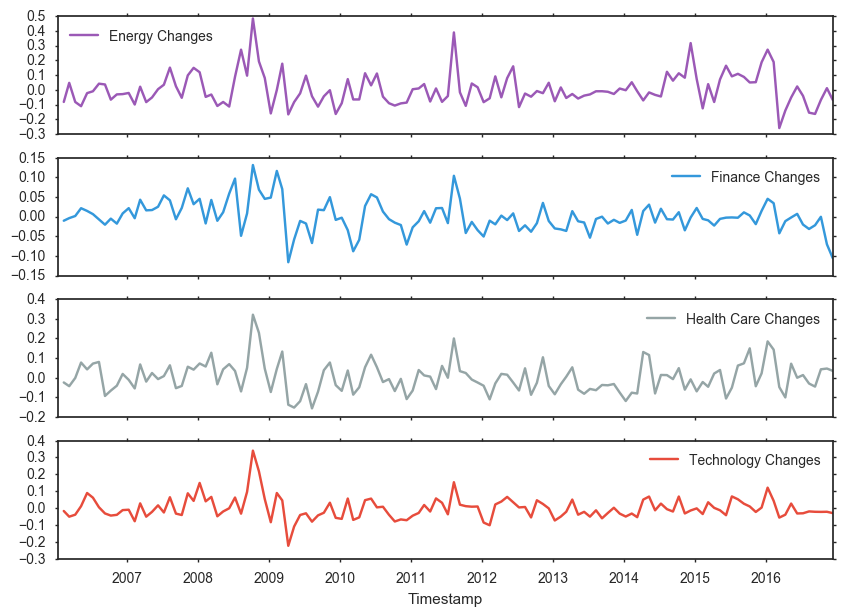

In [30]:
plot_cols = list(delta_avg)

# 2 axes for 2 subplots
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
#delta_df[plot_cols].plot(subplots=True, ax=axes)
delta_avg[plot_cols].plot(subplots=True, ax=axes)
#plt.ylim([-0.20,0.150])
plt.show()

In [31]:
(abs(delta_avg).iloc[1:,:].quantile(q=0.90, axis=0))


Energy Changes         0.163191
Finance Changes        0.059207
Health Care Changes    0.118481
Technology Changes     0.084176
dtype: float64

In [32]:
peak = delta_avg[(abs(delta_avg) >= 0.163191).any(axis=1)]

In [33]:
peak.head()

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
Timestamp,,,,
2008-08-10 10:10:10,0.271934,-0.048996,-0.069831,-0.033595
2008-10-10 10:10:10,0.483709,0.131039,0.320536,0.340418
2008-11-10 10:10:10,0.192015,0.068335,0.228251,0.217602
2009-03-10 10:10:10,0.176872,0.069709,0.133102,0.045064
2009-04-10 10:10:10,-0.167232,-0.116181,-0.137381,-0.224170


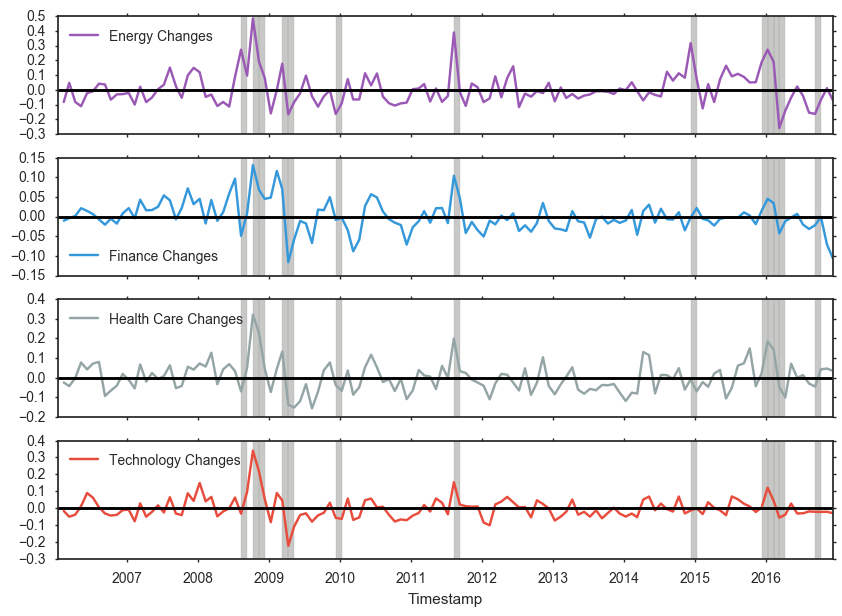

In [34]:
plot_cols = list(delta_avg)

fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
delta_avg[plot_cols].plot(subplots=True, ax=axes)

for shade in range(len(peak)):
    peak_bgn = peak.index[shade]
    if peak.index[shade].month == 12:
        year = peak.index[shade].year+1
        end = (year, 1, 10, 10, 10, 10)
        dt_obj = datetime(*end[0:6])
        peak_end = pd.to_datetime(dt_obj)
        
    else:
        mo = peak.index[shade].month + 1
        end = (peak.index[shade].year, mo, 10, 10, 10, 10)
        dt_obj = datetime(*end[0:6])
        peak_end = pd.to_datetime(dt_obj)
        
    for ax in axes:
        ax.axvspan(peak_bgn, peak_end, color=sns.xkcd_rgb['grey'], alpha=.5)
    
        ax.axhline(0, color='k', linestyle='-', linewidth=1)

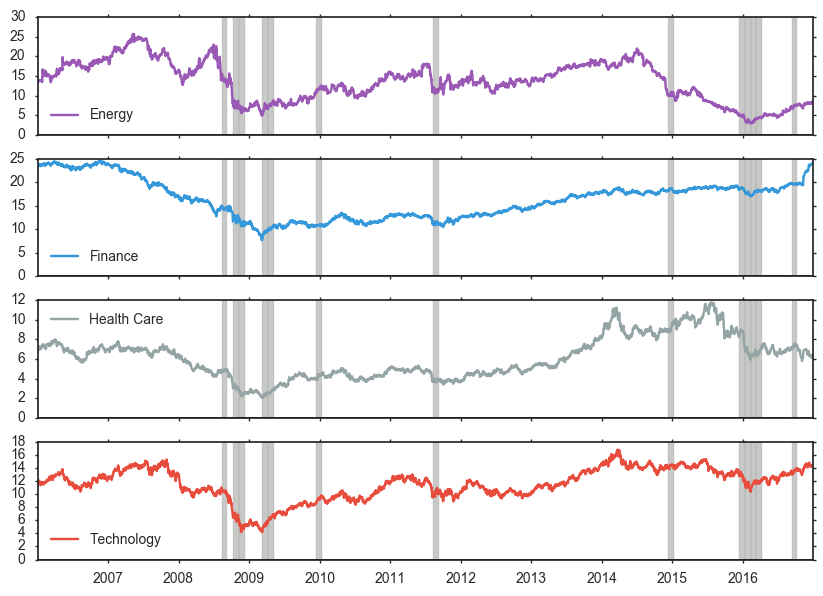

In [35]:
plot_cols = list(avg_T)

fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
avg_T[plot_cols].plot(subplots=True, ax=axes)

for shade in range(len(peak)):
    peak_bgn = peak.index[shade]
    if peak.index[shade].month == 12:
        year = peak.index[shade].year+1
        end = (year, 1, 10, 10, 10, 10)
        dt_obj = datetime(*end[0:6])
        peak_end = pd.to_datetime(dt_obj)
        
    else:
        mo = peak.index[shade].month + 1
        end = (peak.index[shade].year, mo, 10, 10, 10, 10)
        dt_obj = datetime(*end[0:6])
        peak_end = pd.to_datetime(dt_obj)
        
    for ax in axes:
        ax.axvspan(peak_bgn, peak_end, color=sns.xkcd_rgb['grey'], alpha=.5)
    
        ax.axhline(0, color='k', linestyle='-', linewidth=1)

In [36]:
peak.index[0]

Timestamp('2008-08-10 10:10:10')

In [37]:
peak.index[1].month - peak.index[0].month == 0

False

In [38]:
peak_shade = []
for l in range(len(peak)-1):
    if peak.index[l+1].year == peak.index[1].year:
        if peak.index[l+1].month - peak.index[1].month == 1:
            start = peak.index[l]
        else:
            start = peak.index[l-1]
            peak_shade.append(start)
    else:
        start = peak.index[l-1]
        peak_shade.append(start)

In [39]:
peak_shade

[Timestamp('2016-09-10 10:10:10'),
 Timestamp('2008-10-10 10:10:10'),
 Timestamp('2008-11-10 10:10:10'),
 Timestamp('2009-03-10 10:10:10'),
 Timestamp('2009-04-10 10:10:10'),
 Timestamp('2009-12-10 10:10:10'),
 Timestamp('2011-08-10 10:10:10'),
 Timestamp('2014-12-10 10:10:10'),
 Timestamp('2015-12-10 10:10:10'),
 Timestamp('2016-01-10 10:10:10'),
 Timestamp('2016-02-10 10:10:10')]

In [40]:
peak

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
Timestamp,,,,
2008-08-10 10:10:10,0.271934,-0.048996,-0.069831,-0.033595
2008-10-10 10:10:10,0.483709,0.131039,0.320536,0.340418
2008-11-10 10:10:10,0.192015,0.068335,0.228251,0.217602
2009-03-10 10:10:10,0.176872,0.069709,0.133102,0.045064
2009-04-10 10:10:10,-0.167232,-0.116181,-0.137381,-0.224170
2009-12-10 10:10:10,-0.164439,-0.008523,-0.037643,-0.058359
2011-08-10 10:10:10,0.388879,0.103690,0.199786,0.153049
2014-12-10 10:10:10,0.316577,-0.002436,-0.008372,-0.014644
2015-12-10 10:10:10,0.186521,0.014430,0.022265,0.002597


## Test: Which month has the highest volatility?

In [41]:
# double check, would it make more sense to look at sum of absolute changes?
# This wouldn't give us direction though.
abs_delta_df = abs(delta_df)
months = abs_delta_df.groupby(delta_df.index.month).sum()
months

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
1,5.579697,2.292274,3.983668,3.575874
2,5.153948,1.725488,3.177925,2.995240
3,5.517229,2.258931,4.191325,3.491156
4,4.583842,1.896602,3.660335,3.011856
5,5.179666,1.909797,3.654547,3.306427
6,4.531683,2.211246,3.878905,3.338665
7,4.570591,1.928904,3.694508,3.224373
8,5.905949,2.439180,3.975516,3.614457
9,5.347203,2.091582,3.754380,3.259025
10,6.048092,2.669991,4.596439,4.065775


In [42]:
months["total"] = months.sum(axis=1)
months.head()

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes,total
1,5.579697,2.292274,3.983668,3.575874,15.431513
2,5.153948,1.725488,3.177925,2.995240,13.052601
3,5.517229,2.258931,4.191325,3.491156,15.458640
4,4.583842,1.896602,3.660335,3.011856,13.152635
5,5.179666,1.909797,3.654547,3.306427,14.050437


In [43]:
sns.set_style("white")
sns.set_context({"figure.figsize": (20, 10)})

NameError: name 'bottom_plot' is not defined

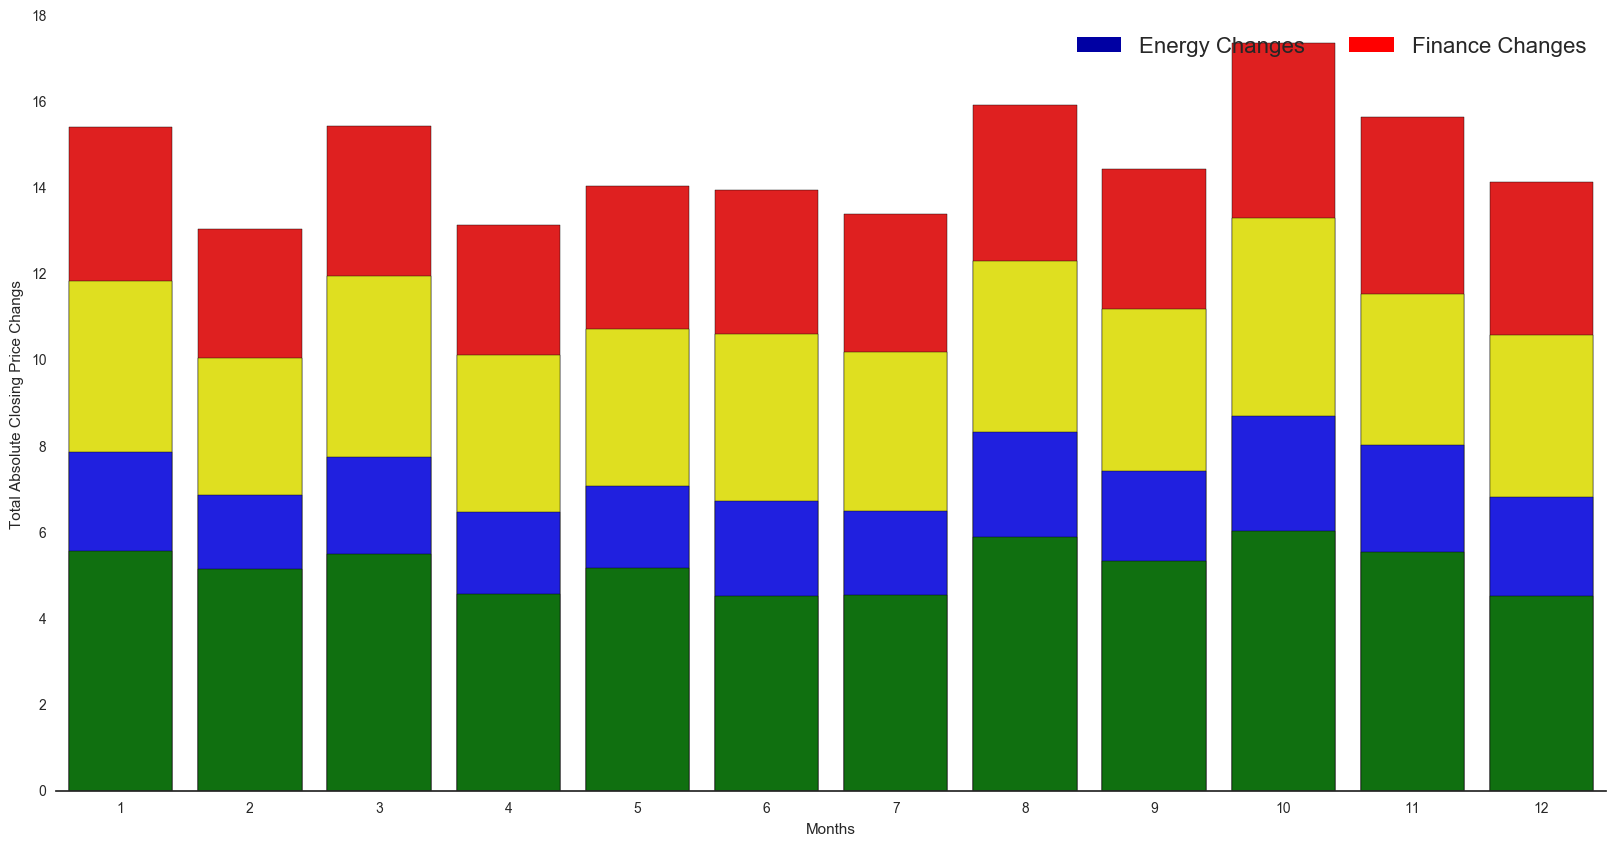

In [44]:
sns.barplot(x = months.index, y = months.total, color = "red")
health_plot = sns.barplot(x = months.index, y = months['Health Care Changes']+months['Energy Changes']+months['Finance Changes'], color = "yellow")
fin_plot = sns.barplot(x = months.index, y = months['Finance Changes']+months['Energy Changes'], color = "blue")
eng_plot = sns.barplot(x = months.index, y = months['Energy Changes'], color = "green")

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Energy Changes', 'Finance Changes'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
eng_plot.set_ylabel("Total Absolute Closing Price Changs")
eng_plot.set_xlabel("Months")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

## Subset Data of Dataframe

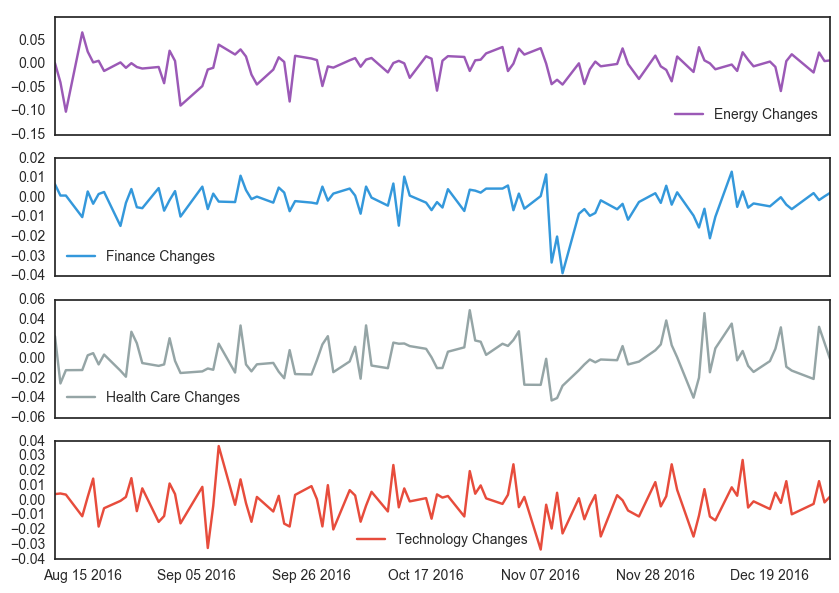

In [45]:
# 261 not right number, why is our last day 12-30-2016? -261 maybe?
year = delta_df.iloc[-100:,:]

plot_cols = list(year)

# 2 axes for 2 subplots
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
#delta_df[plot_cols].plot(subplots=True, ax=axes)
year[plot_cols].plot(subplots=True, ax=axes)
#plt.ylim([-0.20,0.150])
plt.show()

# Collecting Relevant News Articles from The New York Times
###### Objective: Provide context to our time series plots and make historically accurate inferences about the data.
The New York Times [Article Search API](https://developer.nytimes.com/) is capable of extracting decades worth of news records. We utilized the API in order to extract over 9,000 relevant articles, filtered by the four designated sectors. To visualize the data, we have developed an interactive [plot.ly](https://plot.ly/) timeline that allows users to navigate a 10-year period's worth of news headlines.

In [46]:
from nytimesarticle import articleAPI
import time
# OLD KEY (hit my limit): api = articleAPI('2679a66fe8df4740b754f98e52ad068c')
api = articleAPI('e031fcaf03da4b3c949e505c4aa69a5b')
def news_articles(sector,start,end,pages):
    sector_df = pd.DataFrame()
    for i in range(pages):
        try:
            if sector == 'Health Care':
                sector_articles = api.search( 
                    q = 'Health',
                    fq = {
                        'news_desk':'Business',
                        'section_name':'Business',
                        'subject.contains':['Health','Drugs'],
                        'type_of_material':'News'
                    },
                    begin_date = start,
                    end_date = end,
                    sort = 'oldest',
                    page = i
                )
            if sector == 'Technology':
                sector_articles = api.search(
                    fq = {
                        'news_desk.contains':'Business',
                        'section_name':'Technology',
                        'subject.contains':['Acquisitions'],
                        'type_of_material':'News'
                    },
                    begin_date = start,
                    end_date = end,
                    sort = 'oldest',
                    page = i
                )
            if sector == 'Energy':
                sector_articles = api.search( 
                    q = 'Energy & Environment',
                    fq = {
                        'news_desk':'Business',
                        'subject.contains':['Energy','Renewable','Gas','Acquisitions'],
                        'section_name':'Business',
                        'type_of_material':'News'
                    }, 
                    begin_date = start,
                    end_date = end,
                    sort = 'oldest',
                    page = i
                )
            if sector == 'Finance':
                sector_articles = api.search( 
                    q = 'Finance',
                    fq = {
                        'news_desk':'Business',
                        'subject.contains':['Banking','Financial'],
                        'section_name':'Business',
                        'type_of_material':'News'
                    }, 
                    begin_date = start,
                    end_date = end,
                    sort = 'oldest',
                    page = i
                )
            df_i = sector_articles['response']['docs']
            sector_df = sector_df.append(df_i) 
            time.sleep(0.5)   # API only allows 5 calls per second. This slows it down!
        except KeyError:
            break
        except IndexError:
            break
    return sector_df.reset_index()

###### Important Notes:
**Asking for over 100 pages at once (necessary for a 10-year span) leads to unpredictable results.**
* Ideally I would extract news articles using the following call: ```news_articles(<sector>,20060101,20170101,500)```, but the function stops running around 110~120 pages. This is likely due to usage restrictions imposed by the API.
* My solution: Split the desired time frame, make separate calls, concatenate the results, save locally
* Even with this work-around, it took multiple tries to obtain the correct result.

In [47]:
'''
The following code locally stores the news data. Please do not run this block!

healthcare_news1 = news_articles('Health Care',20060101,20091231,100)
healthcare_news2 = news_articles('Health Care',20100101,20131231,100)
healthcare_news3 = news_articles('Health Care',20140101,20161231,100)
healthcare_news = pd.concat([healthcare_news1,healthcare_news2,healthcare_news3],ignore_index=True)
healthcare_news['Sector'] = 'Health Care'
tech_news = news_articles('Technology',100)
tech_news['Sector'] = 'Technology'
energy_news1 = news_articles('Energy',20060101,20091231,100)
energy_news2 = news_articles('Energy',20100101,20131231,100)
energy_news3 = news_articles('Energy',20140101,20161231,100)
energy_news = pd.concat([energy_news1,energy_news2,energy_news3])
energy_news['Sector']='Energy'
finance_news1 = news_articles('Finance',20060101,20091231,100)
finance_news2 = news_articles('Finance',20100101,20131231,100)
finance_news3 = news_articles('Finance',20140101,20161231,100)
finance_news = pd.concat([finance_news1,finance_news2,finance_news3])
finance_news['Sector']='Finance'
all_news = pd.concat([healthcare_news,tech_news,energy_news,finance_news],ignore_index=True)
# all_news.to_pickle('news_df')
'''

"\nThe following code locally stores the news data. Please do not run this block!\n\nhealthcare_news1 = news_articles('Health Care',20060101,20091231,100)\nhealthcare_news2 = news_articles('Health Care',20100101,20131231,100)\nhealthcare_news3 = news_articles('Health Care',20140101,20161231,100)\nhealthcare_news = pd.concat([healthcare_news1,healthcare_news2,healthcare_news3],ignore_index=True)\nhealthcare_news['Sector'] = 'Health Care'\ntech_news = news_articles('Technology',100)\ntech_news['Sector'] = 'Technology'\nenergy_news1 = news_articles('Energy',20060101,20091231,100)\nenergy_news2 = news_articles('Energy',20100101,20131231,100)\nenergy_news3 = news_articles('Energy',20140101,20161231,100)\nenergy_news = pd.concat([energy_news1,energy_news2,energy_news3])\nenergy_news['Sector']='Energy'\nfinance_news1 = news_articles('Finance',20060101,20091231,100)\nfinance_news2 = news_articles('Finance',20100101,20131231,100)\nfinance_news3 = news_articles('Finance',20140101,20161231,100)\n

In [48]:
all_news = pd.read_pickle('news_df')
# Convert dates to index
all_news['pub_date'] = pd.to_datetime(all_news.pub_date)
all_news = all_news.set_index(all_news['pub_date'])

In [49]:
headlines = [d.get('main') for d in all_news.headline]
dates = list(pd.to_datetime(all_news['pub_date']))
# Pandas categorical objects have integer values mapped to them:
sector_levels = all_news['Sector'].astype('category').cat.codes

# Data Frame for plot.ly Timeline:
pltdf = pd.DataFrame(
    {'Date':dates,
     'Title':headlines,
     'Sector':all_news.Sector,  
     'Level':sector_levels
    })

### Timeline:

In [50]:
import plotly.plotly as py
import plotly.graph_objs as go

fig = {
    'data': [
        {
            'x': pltdf[pltdf['Sector']==sector]['Date'],
            'y': pltdf[pltdf['Sector']==sector]['Level'],
            'text': pltdf[pltdf['Sector']==sector]['Title'],
            'name': sector, 'mode': 'markers',
        } for sector in reversed(all_news['Sector'].astype('category').cat.categories)
        ]
    }
py.iplot(fig, filename='plotly_test')

# Analysis of Vocabulary in News Headlines
Though the timeline is a cool concept, its scope is too wide to make any substantial conclusions. To further our analysis on average stock prices, we return to the volatility plots, specifically focusing on the shaded regions of highest volatiliy. From these time periods, we analyzed the text from snippets of the articles to calculate word frequencies. The top 100 words from each sector were selected and displayed on a word cloud.

In [51]:
import string
import nltk
import regex as re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import wordcloud

In [52]:
tokenize = nltk.word_tokenize
def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 
# http://stackoverflow.com/questions/11066400/remove-punctuation-from-unicode-formatted-strings
def remove_punctuation(text):
    return re.sub(ur"\p{P}+", "", text)

In [69]:
def CloudPlots(data):
    text = data.lead_paragraph.str.cat(sep = ' ')
    text = text.lower()
    text = remove_punctuation(text)
    tokens = tokenize(text)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    filtered = stem(filtered)
    count = Counter(filtered)
    # top 100 words:
    top_words = dict(count.most_common(100))
    cloud = wordcloud.WordCloud(background_color="white")
    wc = cloud.generate_from_frequencies(top_words)
    return(wc)

In [70]:
peak

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
Timestamp,,,,
2008-08-10 10:10:10,0.271934,-0.048996,-0.069831,-0.033595
2008-10-10 10:10:10,0.483709,0.131039,0.320536,0.340418
2008-11-10 10:10:10,0.192015,0.068335,0.228251,0.217602
2009-03-10 10:10:10,0.176872,0.069709,0.133102,0.045064
2009-04-10 10:10:10,-0.167232,-0.116181,-0.137381,-0.224170
2009-12-10 10:10:10,-0.164439,-0.008523,-0.037643,-0.058359
2011-08-10 10:10:10,0.388879,0.103690,0.199786,0.153049
2014-12-10 10:10:10,0.316577,-0.002436,-0.008372,-0.014644
2015-12-10 10:10:10,0.186521,0.014430,0.022265,0.002597


**We have visualized two periods where the volatility persisted for an exceptional length:**
* 8/2008 to 11/2008
* 12/2015 to 3/2016

In [71]:
# (1) Subset the data:
sample1 = all_news['2008-8-10 10:10:10':'2008-11-10 10:10:10']
sample1_sector = sample1.groupby("Sector")  # a groupby object

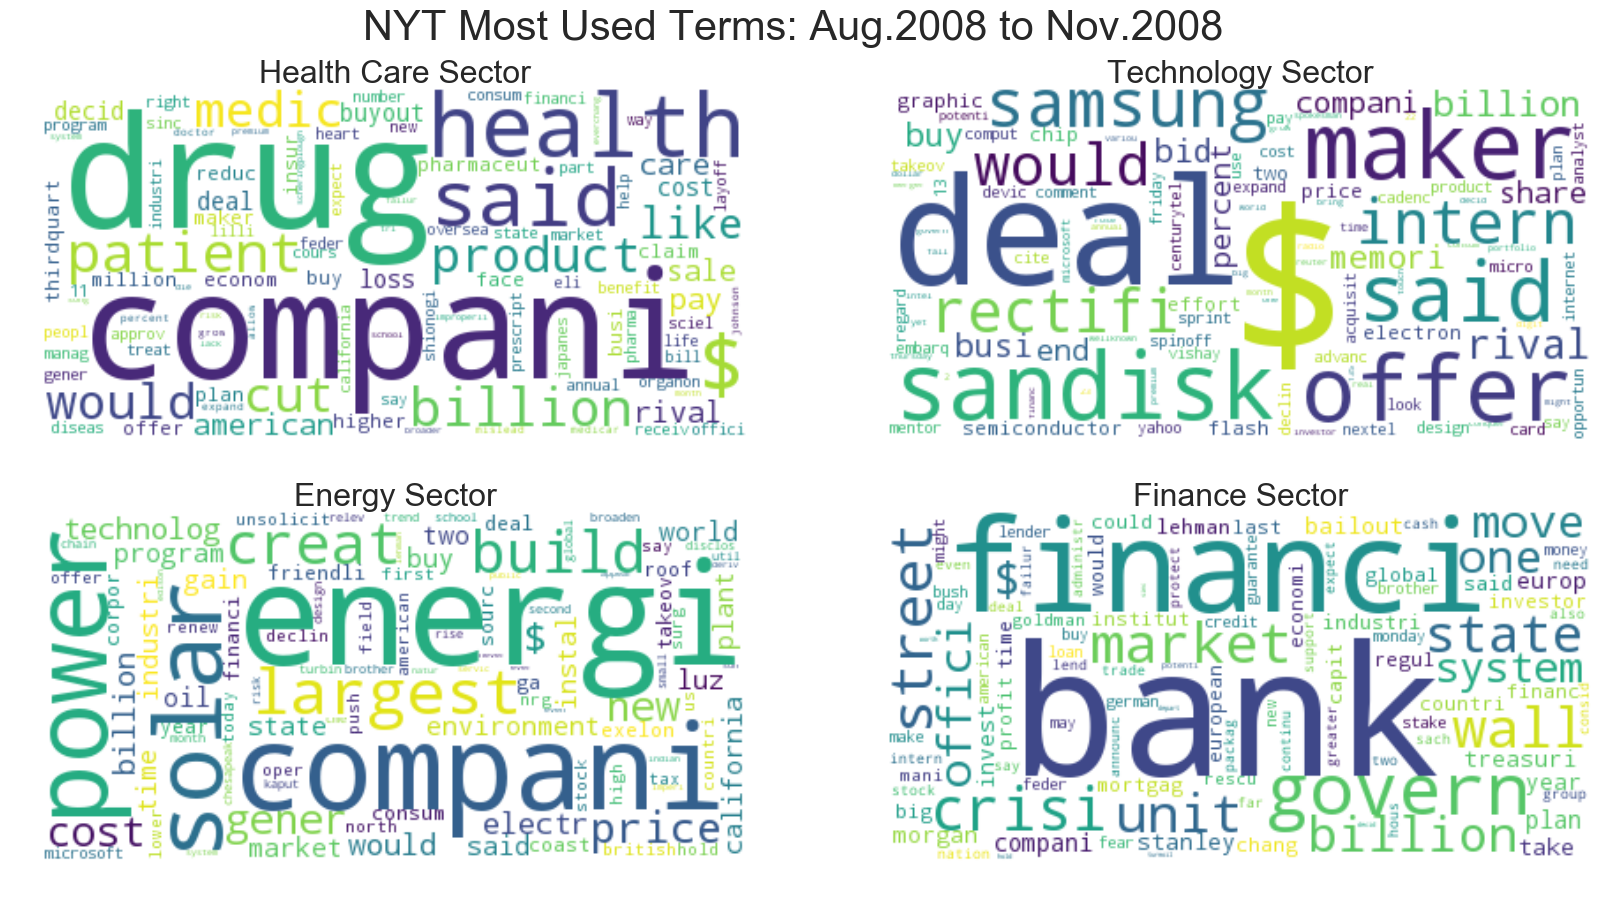

In [72]:
fig = plt.figure()
fig.suptitle("NYT Most Used Terms: Aug.2008 to Nov.2008", fontsize=30)
for counter, sect in enumerate(all_news.Sector.unique()):
    wc = CloudPlots(sample1_sector.get_group(sect))
    ax = fig.add_subplot(2,2,counter+1)
    ax.set_title("%s Sector" %sect,fontsize=23)
    plt.imshow(wc)
    plt.axis("off")

Here is the first set of word clouds. Each sector has several key words that dominate their respective plot, and notably, there are very few instances of these terms overlapping. For example, the stemmed version of the word "company" appears quite often in both articles from the Health Care and Energy sectors, but the most frequently used word from the financial sector articles ("bank") is nowhere to be found on the other three plots.

In [73]:
# (2) Subset the data:
sample2 = all_news['2015-12-10 10:10:10':'2016-03-10 10:10:10']
sample2_sector = sample2.groupby("Sector")

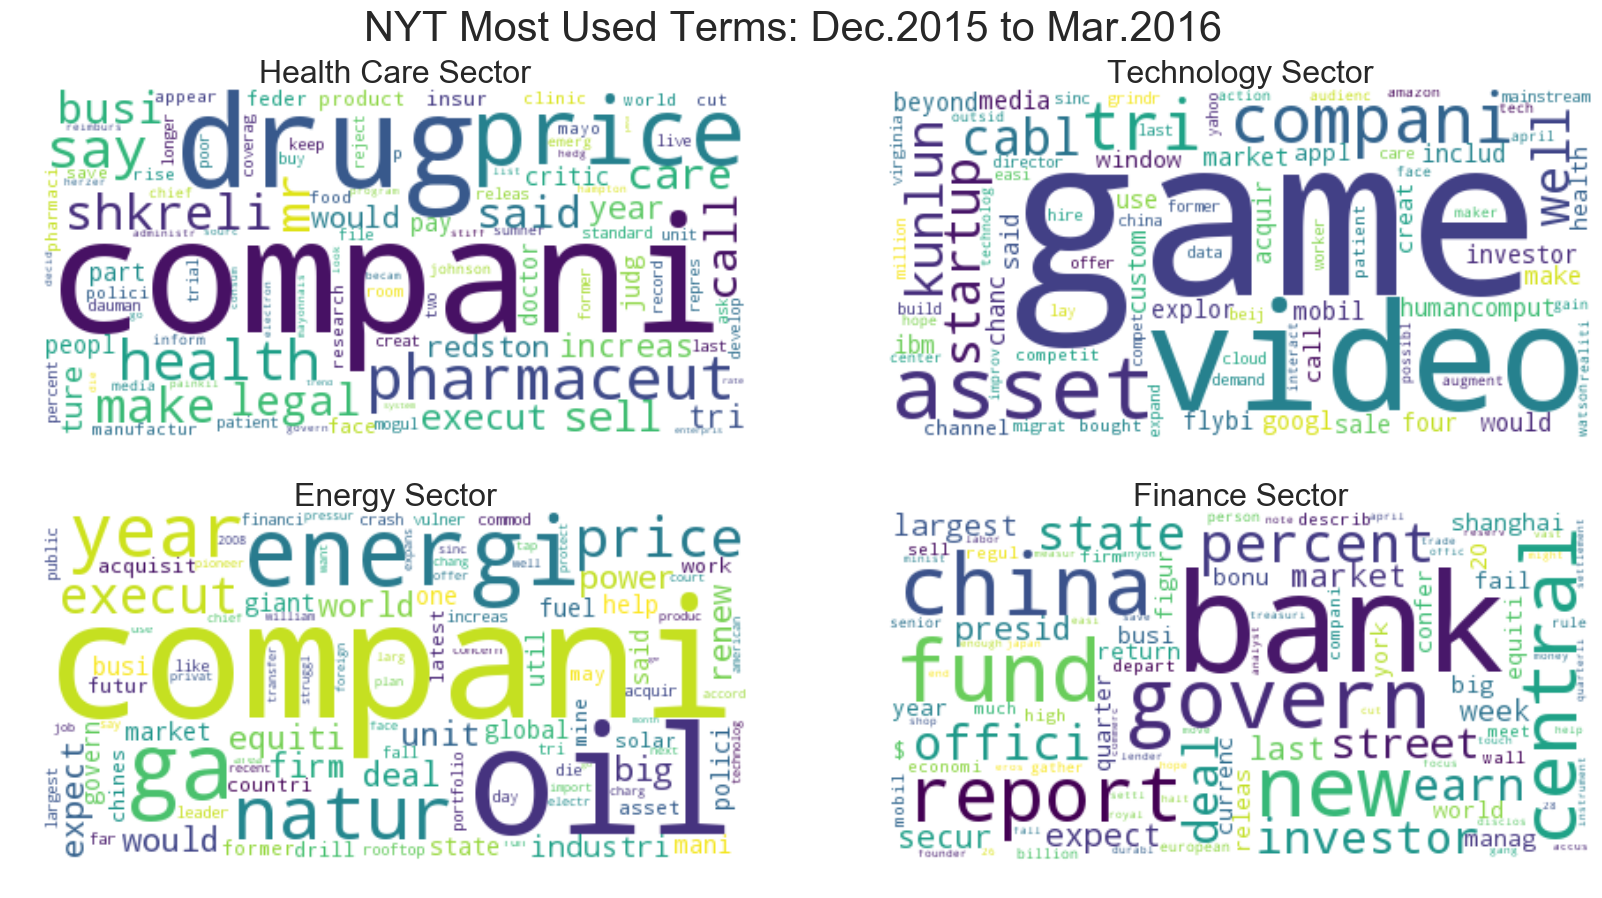

In [74]:
fig = plt.figure()
fig.suptitle("NYT Most Used Terms: Dec.2015 to Mar.2016", fontsize=30)
for counter, sect in enumerate(all_news.Sector.unique()):
    wc = CloudPlots(sample2_sector.get_group(sect))
    ax = fig.add_subplot(2,2,counter+1)
    ax.set_title("%s Sector" %sect,fontsize=23)
    plt.imshow(wc)
    plt.axis("off")

# Time Series Analysis

In [75]:
ts_eng = delta_df['Energy Changes']
# Why do we get an NA for Nov 1 2016?
# Need to change following date range
# ts_eng['2016-11-02':'2017-03-01']

## Check Stationarity

Dickey-Fuller Test: tests the null hypothesis of whether a u nit root is present in an autoregressive model.  

In [76]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


test_stationarity(ts_eng)

In [77]:
testE = delta_df["Energy Changes"]

# Energy Sector Time Series

In [78]:
E_log = np.log(avg_T.iloc[-365:,:]['Health Care'])

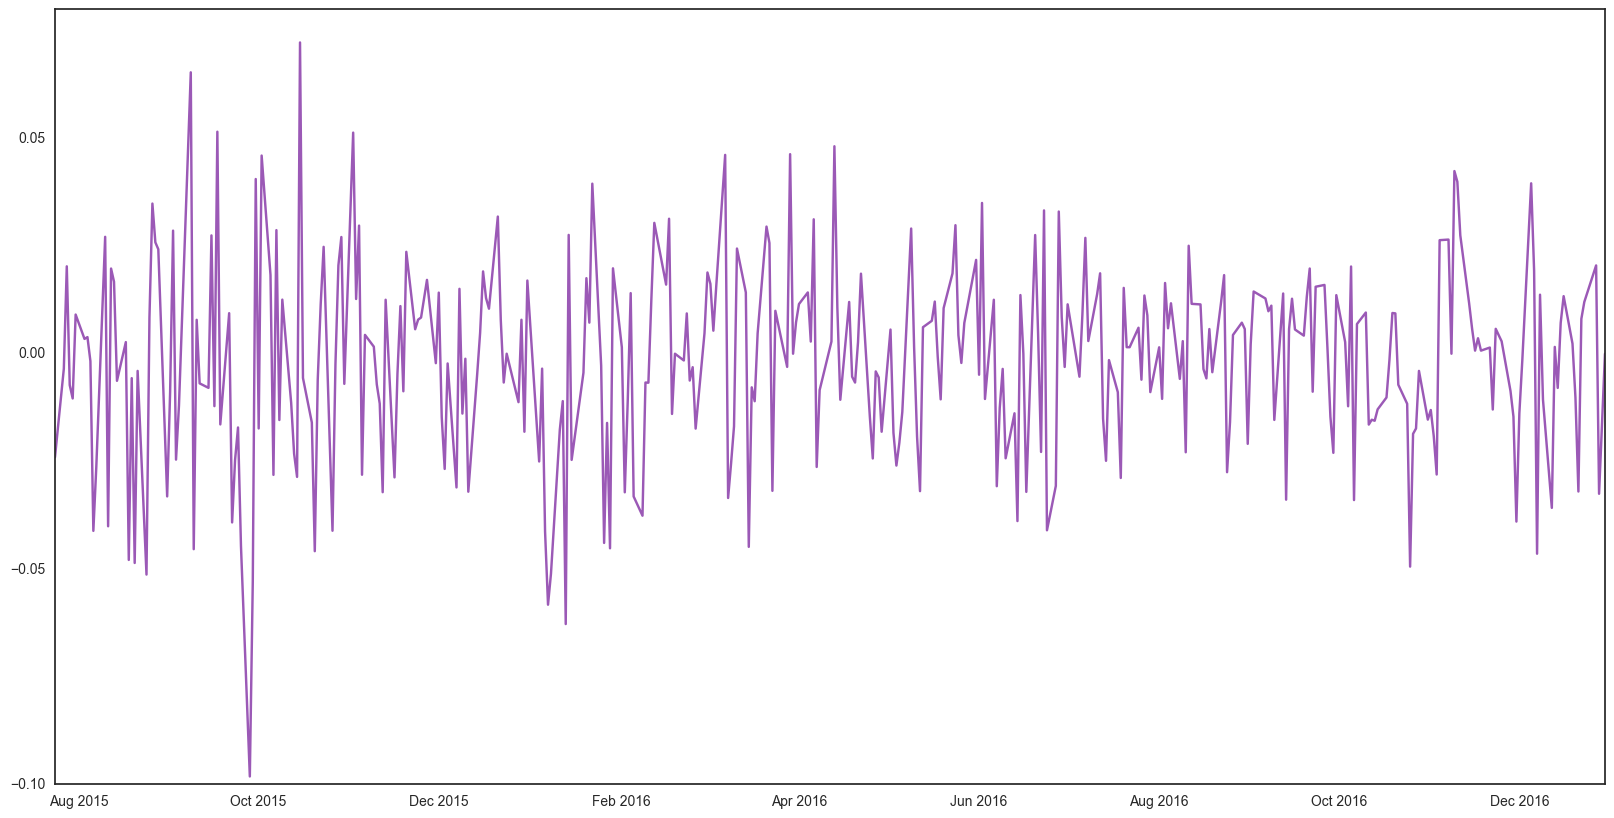

In [79]:
E_log_diff = E_log - E_log.shift()
plt.plot(E_log_diff)

(-0.15, 0.15)

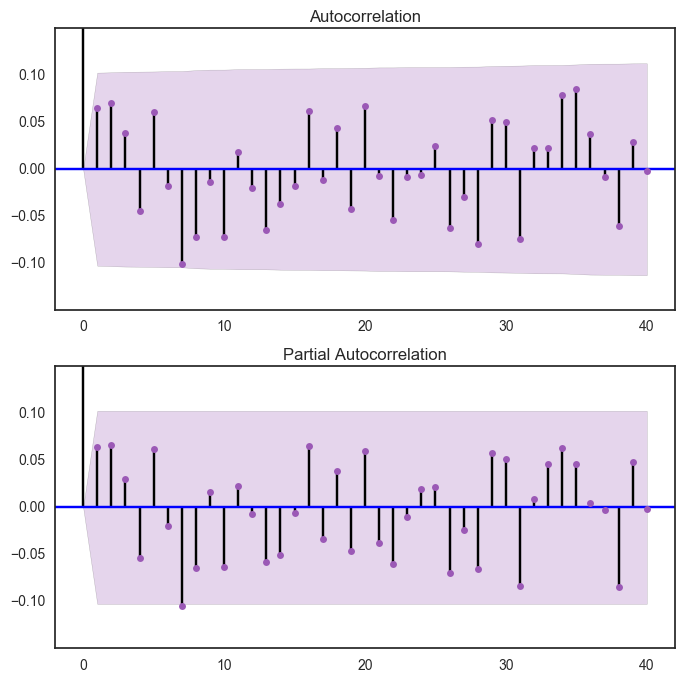

In [80]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211) 
fig = sm.graphics.tsa.plot_acf(E_log_diff[1:].values.squeeze(),lags = 40,ax=ax1)
plt.ylim([-0.15,0.15])
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(E_log_diff[1:],lags =40, ax= ax2)
plt.ylim([-0.15,0.15])

/Users/Homieknights/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/Users/Homieknights/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



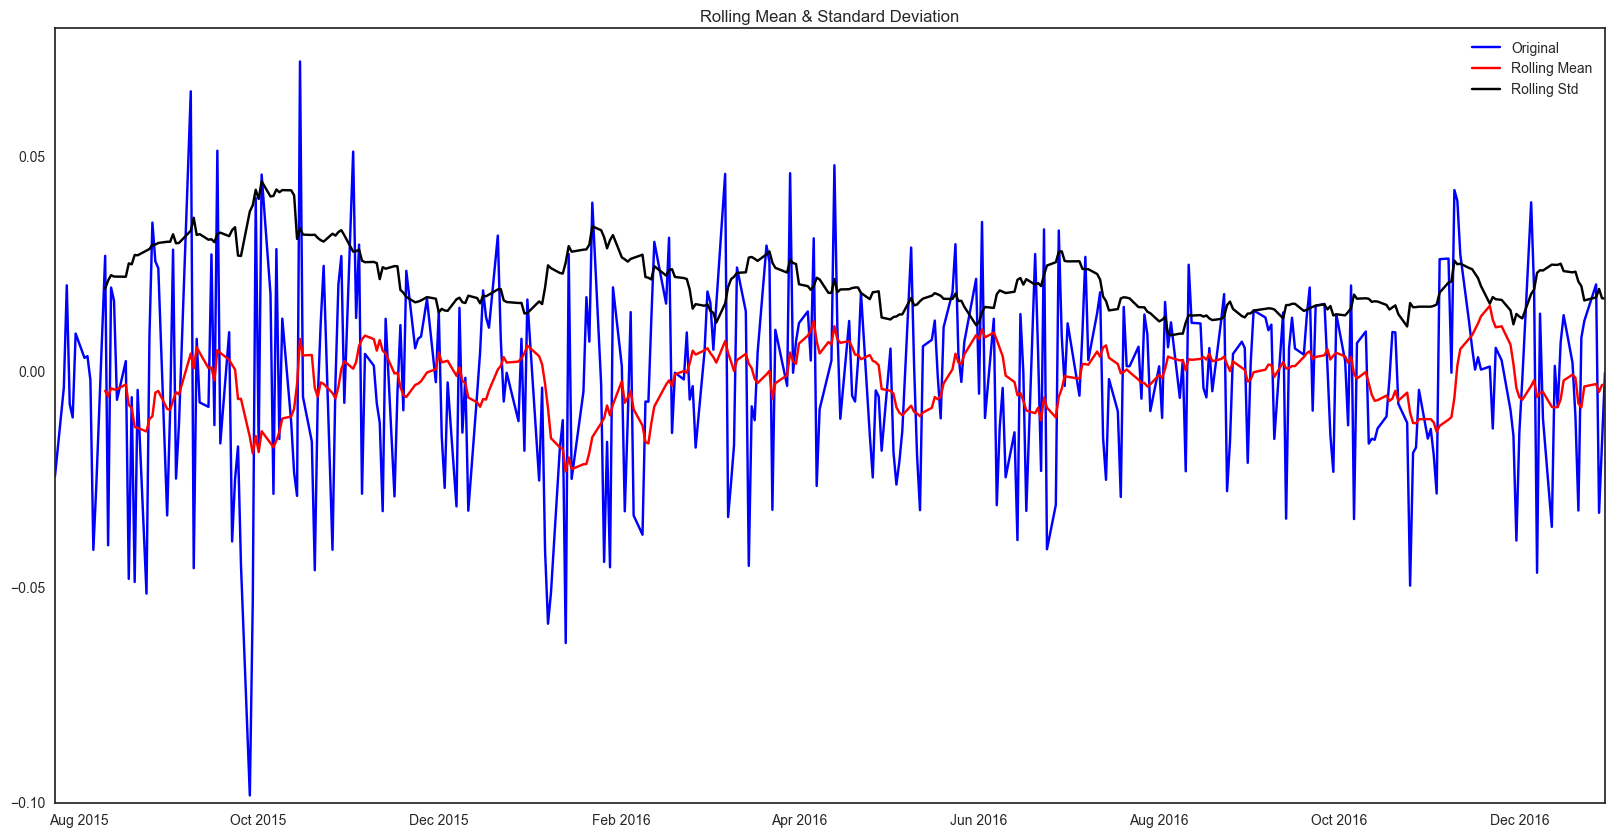

Results of Dickey-Fuller Test:
Test Statistic                -1.783212e+01
p-value                        3.130286e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.630000e+02
Critical Value (5%)           -2.869535e+00
Critical Value (1%)           -3.448494e+00
Critical Value (10%)          -2.571029e+00
dtype: float64


In [81]:
E_log_diff.dropna(inplace=True)
test_stationarity(E_log_diff)